## Load Packages and Setup

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns #dont need for production
import sys

import pytesseract

base_path = 'Sample_Book_Pictures/'
img_paths = [base_path + p for p in 
            ['image.jpg', 'image_1.jpg', 'image2.jpg',
            'IMG_1435.jpg', 'IMG_1436.jpg', 'IMG_1437.jpg', 'IMG_1438.jpg', 
             'IMG_1439.JPG', 'IMG_1442.jpg', 
            ]]

## Individual Functions

### Helper function for looking at several images

In [2]:
def show_images(images, labels=False, columns=1, scale=1, cmap=None, tight=False):
    '''
    Shows any number of images.  Images + Labels should be passed in as arrays
    Labels / columns / scale / and color map are all optional.
    Method will try to automaitcally adjust size and layout based on number of columns desired.
    Scale changes the wdith and height of the entire figure.
    '''
    if len(images) < 2 : return "note for single images mate"

    if not labels:
        labels = ['Image ' + str(n) for n in range(1, len(images)+1)]
    assert len(labels) == len(images)

    n_images = len(images)
    rows = np.ceil(len(images)/float(columns))

    fig = plt.figure()
    for n, (image, label) in enumerate(zip(images, labels)):
        a = fig.add_subplot(rows, columns, n + 1)
        if image.ndim == 2:
            plt.gray()
        a.imshow(image, cmap=cmap)
        a.set_title(label), a.set_xticks([]), a.set_yticks([])
    
    x, y = fig.get_size_inches()
    fig.set_size_inches(x*scale, y)
    if tight:
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.tight_layout()
    plt.show()

### Sobel Edge Detection

In [3]:
def get_sobelx(img):
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (3,3), 0)

    sobelx = cv2.Sobel(src=im_gray, ddepth=cv2.CV_8UC1, dx=1, dy=0)
    sobely = cv2.Sobel(src=im_gray, ddepth=cv2.CV_8UC1, dx=0, dy=1)
    
    return sobelx

### Remove Duplicate Lines and Extend Lines from Top to Bottom

In [4]:
def remove_duplicate_lines(lines, threshold):
    output_lines = []
    used_x = np.array((0))
    for line in lines:
        cur_x1 = line[0]
        
        smallest_diff = np.min(np.abs(used_x - cur_x1))
        
        if smallest_diff > threshold:
            output_lines.append(line)
            used_x = np.append(used_x, cur_x1)

    return(output_lines)

def extend_lines(lines, height):
    ext_lines = []
    for line in lines:
        ext_lines.append(extend_line(line, height))
        
    return ext_lines

def extend_line(line, img_height):
    x3, y3 = extend_line_to_bottom2(line, img_height)
    x0, y0 = extend_line_to_top2(line)

    return [x0, y0, x3, y3]

def extend_line_to_bottom2(line, height):
    [x1, y1, x2, y2] = line
    slope = (y2-y1) / (x2-x1)

    if slope > 0:
        x3, y3 = x2, y2
        while(y3 < height):
            x3 = x3 + 1
            y3 = y3 + slope
    
    if slope < 0:
        x3, y3 = x2, y2
        while(y3 < height):
            x3 = x3 - 1
            y3 = y3 - slope

    return (x3, height)

def extend_line_to_top2(line):
    [x1, y1, x2, y2] = line
    slope = (y2-y1) / (x2-x1)

    lenAB = math.sqrt(math.pow(x1 - x2, 2.0) + math.pow(y1 - y2, 2.0))
    # print('x1, y1, x2, y2 ', line, "   -- slope = ", round(slope, 2), " -- length ", lenAB)

    if slope > 0:
        x0, y0 = x1, y1
        while(y0 > 0):
            x0 = x0 - 1
            y0 = y0 - slope
    
    if slope < 0:
        x0, y0 = x1, y1
        while(y0 > 0):
            x0 = x0 + 1
            y0 = y0 + slope

    y0 = 0
    return(x0, y0)    
    

### HoughLines Line Detection and Extension

In [5]:
def detect_lines(sobelx):
    deg = 0.75
    lines = cv2.HoughLinesP(sobelx, 1, (deg/180 * 3.14159), 100, minLineLength= 500, maxLineGap=5)
    lines = [list(l[0])for l in lines]
    
    return lines

def visualize_found_lines(lines, img):
    for i in range(len(lines)):
        [x1, y1, x2, y2] = lines[i]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
    _ = cv2.imwrite(f'lines.jpg', img)
    print('image written')

### Cut image into slices

In [6]:
def slice_image(lines, img):
    lines = sorted(lines, key=lambda x: x[0])
    slices = []
    
    for i in range(1, len(lines)):
        x1, y1, x2, y2 = lines[i]
        x3, y3, x4, y4 = lines[i-1]

        pts =[[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
        pts = np.array(pts)
        rect = cv2.boundingRect(pts)
        x,y,w,h = rect
        
        t_cropped = img[y:y+h, x:x+w].copy()
        slices.append(t_cropped)

    return(slices)

### Extract Label

In [17]:
# self
def extract_label(im_slice, min_white_threshold = 200, label_threshold = 180):
        im_hsl = cv2.cvtColor(im_slice, cv2.COLOR_BGR2HLS)
        im_white = cv2.inRange(im_hsl,  np.array([0,min_white_threshold,0]), 
                                        np.array([255,255,255]))
        
        kernel_height = 20
        kernel_step   = 10
        kernel_top    = 0
        white_values  = []
        
        while(kernel_top < im_white.shape[0]):
            avg_white = np.mean(im_white[kernel_top:kernel_top+kernel_height, :])
            white_values.append(avg_white)
            kernel_top += kernel_step
        
        # calculate the top 5% of whiteness in the picture
        n = int(len(white_values) * 0.95)
        label_threshold = int(sorted(white_values)[n])
        
        top_at    = None
        bottom_at = None
        found_top = False
        for i in range(len(white_values)):
            if white_values[i] > label_threshold:
                if not top_at: 
                    top_at = (i * kernel_step) #+ kernel_height
                else: 
                    bottom_at = (i * kernel_step) + kernel_height

        cropped = im_slice[top_at:bottom_at, :].copy()

        return [cropped, im_white, white_values]

### Convert Label to String

In [8]:
def label2string(label):
    config = '--oem 3 --psm 6'
    ocr_result = pytesseract.image_to_string(label, config = config, lang='eng')
    return ocr_result

### Convert output to call number

In [9]:
def string2call_number(ocr_result):
    if ocr_result:
        ocr_result = ocr_result.strip()
        split_results = ocr_result.split('\n')

        split_results = [''.join(filter(str.isalnum, e)) for e in split_results]

        for i, line in enumerate(split_results):
            if split_results[i].replace('.',"").isnumeric() and split_results[i+1].isalpha():
                call_number = (split_results[i], split_results[i+1])
                if len(call_number[0]) > 3:
                    cnum = call_number[0][0:3] + '.' + call_number[0][3:]
                    call_number = (cnum, call_number[1])
                    
                return(call_number)
    else : return None

### Create the dictionary of books and OutOfOrder Results
- determine if a book is out of order
- assumes a list of tuples ('###', 'AAA')

In [10]:
def call_numbers2dict_results(call_numbers):
    #determine direction ascending or descending of first two books
    if call_numbers[0] > call_numbers[1] : descending = True
    else : descending = False

    results = []
    #add in first book
    results.append({'shelf' : 1, 'book_number' : 1, 'call_number' : call_numbers[0], 'out_of_order' : False})

    #loop through the remaining books and check each book is in order according to the flag
    for idx in range(1, len(call_numbers)):
        #create a list of dictionaries
        if descending:
            if call_numbers[idx-1] > call_numbers[idx]:
                results.append({'shelf' : 1, 'book_number' : idx+1, 'call_number' : call_numbers[idx], 'out_of_order' : False})
            else:
                results.append({'shelf' : 1, 'book_number' : idx+1, 'call_number' : call_numbers[idx], 'out_of_order' : True})
        else:
            if call_numbers[idx-1] < call_numbers[idx]:
                results.append({'shelf' : 1, 'book_number' : idx+1, 'call_number' : call_numbers[idx], 'out_of_order' : False})
            else:
                results.append({'shelf' : 1, 'book_number' : idx+1, 'call_number' : call_numbers[idx], 'out_of_order' : True})
    return results

## Full Run

Sample_Book_Pictures/image_1.jpg


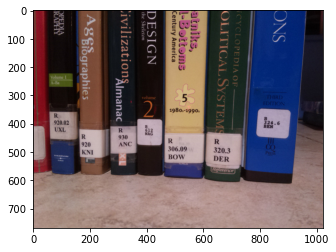

In [52]:
#Load Image
img_num = 1
print(img_paths[img_num])
im_bgr = cv2.imread(img_paths[img_num])
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [53]:
#edge and line detection
sobelx = get_sobelx(im_bgr)
lines = detect_lines(sobelx)
print("found ", len(lines), " lines")

img_height = im_bgr.shape[0]
extended_lines = extend_lines(lines, img_height)
extended_lines = remove_duplicate_lines(extended_lines, 50)
print("kept ", len(extended_lines), " lines")

visualize_found_lines(extended_lines, np.copy(im_rgb))

#slice up image into (hopefully) individual books
slices = slice_image(extended_lines, im_bgr)
print(f'{len(slices)} slices created')

found  9  lines
kept  5  lines
image written
4 slices created


In [62]:
#extract labels from slices and get call numbers
call_numbers = []
labels = []

print('on slice# ', end=' ')

for i, s in enumerate(slices):
    print(i+1, end='')
    ocr_results = None
    label, im_white, white_values = extract_label(s)
    labels.append(label)
    if type(label) is np.ndarray:
        ocr_result = label2string(s)
        # print(ocr_result)
    if ocr_result:
        call_number = string2call_number(ocr_result)
        call_numbers.append(call_number)
        
print('\nlabel results:')
print(call_numbers)

#turn call numbers into results to send back (list of dicts)
results = call_numbers2dict_results(call_numbers)

print('results [{}]')
print(results)

on slice#  1234
label results:
[None, ('2', 'fo'), ('198.01990', 'R'), ('324.6', 'BEN')]


TypeError: '>' not supported between instances of 'NoneType' and 'tuple'

/var/folders/k1/h6ng9tm55_n3hffyrndk3sfw0000gq/T/ipykernel_46536/2617945046.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(rows, columns, n + 1)


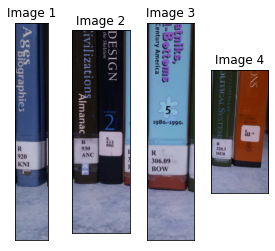

In [55]:

show_images(slices, columns=5)

In [64]:
cv2.imwrite('book_slice.jpg', slices[0])

True

/var/folders/k1/h6ng9tm55_n3hffyrndk3sfw0000gq/T/ipykernel_46536/2617945046.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(rows, columns, n + 1)


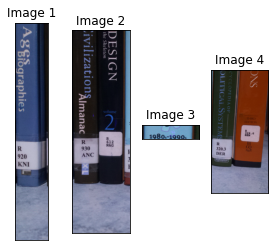

In [63]:
show_images(labels, columns=5)

In [69]:
cropped, im_white, white_values = extract_label(slices[0])

In [71]:
np.unique(white_values)

array([0.])

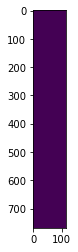

In [70]:
plt.imshow(im_white)

edge cases
- if the first two tuples are equal
- if the first two books are out of order and the descending flag is incorrect


In [ ]:
test_call_numbers = [[('930', 'ANC'), ('815', 'TUF'), ('820', 'TIB')], 
                    [None, ('612', 'NAG'), ('612', 'BIL')]]

flat_call = []
for each in test_call_numbers:
    flat_call.extend(each)

len(test_call_numbers)

In [ ]:
cv2.Stitcher_create()

In [ ]:

test_call_numbers = [[None, ('612', 'NAG'), ('613', 'NAG'), ('612', 'BIL')],
                    [('815', 'TUF'), ('820', 'TIB'), ('930', 'ANC')]]
print(process_results(test_call_numbers))

In [ ]:
pytesseract.image_to_boxes(labels[2])

In [51]:
test_data = [{'shelf': 1, 'book_number': 1, 'call_number': ('612', 'NAG'), 'out_of_order': False},
            {'shelf': 1, 'book_number': 2, 'call_number': ('801.1', 'TED'), 'out_of_order': True},
            {'shelf': 1, 'book_number': 3, 'call_number': ('612', 'BIL'), 'out_of_order': False},]
keys = test_data[0].keys()
keys = [each for each in keys]
print(keys)
for each in test_data:
    for k,v in each.items():
        print(',', v, end='')
    print()

['shelf', 'book_number', 'call_number', 'out_of_order']
, 1, 1, ('612', 'NAG'), False
, 1, 2, ('801.1', 'TED'), True
, 1, 3, ('612', 'BIL'), False


In [ ]:
shelf, book_number, call_number, call_letters, out_of_order
1, 1, 612, NAG, False
1, 2, 801.1, TED, True
1, 3, 612, BIL, False